In [1]:
import pandas as pd
from gurobipy import *
import math

def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Load datasets
cities_df = pd.read_csv('./cities_small.csv')
packages_df = pd.read_csv('./packages_small.csv')

# Create a distance matrix
distances = {}
for i, row_i in cities_df.iterrows():
    for j, row_j in cities_df.iterrows():
        dist = euclidean_distance(row_i['lat'], row_i['lon'], row_j['lat'], row_j['lon'])
        distances[(int(row_i['id']), int(row_j['id']))] = dist

# Create a distance matrix
packages = {}
for i, row_i in packages_df.iterrows():
    packages[(row_i['origin'], row_i['destination'])] = row_i['packages']

for i in range(len(cities_df)):
    for j in range(len(cities_df)):
        if (i, j) not in packages:
            packages[(i, j)] = 0

print(distances)
print(packages)
print(len(distances))
print(len(packages))

{(0, 0): 0.0, (0, 1): 7.385265389230029, (0, 2): 38.15591593897656, (0, 3): 17.84376868899152, (0, 4): 5.408813028490058, (0, 5): 25.773889892811205, (0, 6): 41.49611653074913, (0, 7): 48.60553382145602, (0, 8): 39.29147706731318, (0, 9): 42.082014644191126, (0, 10): 34.74170158291984, (0, 11): 10.870017183439154, (0, 12): 28.091268550605463, (0, 13): 48.30461965636616, (0, 14): 30.044770767831277, (0, 15): 51.58763290393545, (0, 16): 11.176730921164692, (1, 0): 7.385265389230029, (1, 1): 0.0, (1, 2): 30.821370630396732, (1, 3): 11.140535810559616, (1, 4): 3.8947956806280275, (1, 5): 18.392032084910486, (1, 6): 34.214148100004024, (1, 7): 41.54601148997632, (1, 8): 32.38476390072753, (1, 9): 34.69721975018226, (1, 10): 27.874962861114362, (1, 11): 5.678534987172922, (1, 12): 20.7273715847404, (1, 13): 41.242281307611485, (1, 14): 23.63088834930368, (1, 15): 44.590700193329695, (1, 16): 4.106552016136462, (2, 0): 38.15591593897656, (2, 1): 30.821370630396732, (2, 2): 0.0, (2, 3): 21.180

In [2]:
X_dict = {}
Y_dict = {}
obj_dict = {}
C_list = [10, 20, 30, 40, 50, 60]

for C in C_list: 
    # Initialize model
    model = Model("FreshFarm")

    N = len(cities_df)

    # Decision variables
    X = model.addVars(N, vtype=GRB.BINARY, name="x")
    Y = model.addVars(N, N, vtype=GRB.BINARY, name="y")
    Z = model.addVars(N, N, vtype=GRB.BINARY, name="z")  # Introduced for X[i] * X[j]
    W = model.addVars(N, N, N, vtype=GRB.BINARY, name="w") # Introduced for Y[i, k] * Y[k, j] * (1 - Xi * Xk * Xj)
    U = model.addVars(N, N, N, vtype=GRB.BINARY, name="u") # Introduced for Xi * Xk * Xj
    V = model.addVars(N, N, N, N, vtype=GRB.BINARY, name="v")  # Introduced for Y[i, m] * Y[m, n]  * Y[n, j] * (1 - Xi) * Xm * Xn * (1 - Xj)

    # Objective function with alpha = 0.75
    alpha = 0.75
    K = 2
    d = distances
    f = packages
    M = N

    # Objective Function
    obj_expr = LinExpr()

    # Spoke to hub, hub to hub, hub to spoke
    obj_1 = quicksum(Y[i, j] * f[(i, j)] * (d[(i, j)] - Z[i, j] * (1 - alpha) * d[(i, j)]) for i in range(N) for j in range(N) if i != j)

    # Spoke-hub-spoke, s-h-h, h-h-s
    obj_2 = quicksum(W[i, k, j] * f[(i, j)] * (d[(i, k)] + d[(k, j)] - Z[k, j] * (1 - alpha) * d[(k, j)] - Z[i, k] * (1 - alpha) * d[(i, k)])  
                        for i in range(N) for j in range(N) for k in range(N) if i != k and i != j and k != j)

    # s-h-h-s remains unchanged as it doesn't involve direct multiplication of decision variables
    obj_3 = quicksum(V[i, m, n, j] * f[(i, j)] * (d[(i, m)] + alpha * d[(m, n)] + d[(n, j)]) 
                        for i in range(N) for j in range(N) for m in range(N) for n in range(N) if i != m and i != n and i != j and m != n and m != j and n != j)

    # Overheaded cost
    overhead_cost_1 = quicksum(W[i, k, j] * f[(i, j)] * C for i in range(N) for j in range(N) for k in range(N) if i != k and i != j and k != j) 
    overhead_cost_2 = quicksum(V[i, m, n, j] * f[(i, j)] * 2 * C for i in range(N) for j in range(N) for m in range(N) for n in range(N) if i != m and i != n and i != j and m != n and m != j and n != j) 

    obj_expr = obj_1 + obj_2 + obj_3 + overhead_cost_1 + overhead_cost_2

    model.setObjective(obj_expr, sense=GRB.MINIMIZE)

    # Constraints
    model.addConstr(quicksum(X[i] for i in range(N)) == K)
    for i in range(N):
        model.addConstr(Y[i, i] == 0) # No connnection to itself

        # 1 spoke should only connect to one hub
        model.addConstr(quicksum(Y[i, j] for j in range(N)) <= 1 + M * X[i]) 
        model.addConstr(quicksum(Y[i, j] for j in range(N)) >= 1 - X[i])

        for j in range(N):
            # model.addConstr(Y[i, j] == X[i] * X[j] * (1 - X[i] + X[j]))
            # No connection between spokes, Mush have links between hubs
            # if Xi = Xj = 1, Yij = 1; if Xi = Xj = 0, Yij = 0; Yij = any otherwise
            if i != j:
                model.addConstr(Y[i, j] >= X[i] + X[j] - 1)
                model.addConstr(Y[i, j] <= X[i] + X[j])

            # invertible
            model.addConstr(Y[i, j] == Y[j, i])

            # Zij = Xi * Xj
            model.addConstr(Z[i, j] <= X[i])
            model.addConstr(Z[i, j] <= X[j])
            model.addConstr(Z[i, j] >= X[i] + X[j] - 1)
            for k in range(N):
                # Uikj = Xi * Xk * Xj
                model.addConstr(U[i, k, j] <= X[i])
                model.addConstr(U[i, k, j] <= X[k])
                model.addConstr(U[i, k, j] <= X[j])
                model.addConstr(U[i, k, j] >= X[i] + X[k] + X[j] - 2)

                # Wikj = Y[i, k] * Y[k, j] * (1 - Xi * Xk * Xj) = Y[i, k] * Y[k, j] * (1 - U[i, k, j])
                model.addConstr(W[i, k, j] <= Y[i, k])
                model.addConstr(W[i, k, j] <= Y[k, j])
                model.addConstr(W[i, k, j] <= 1 - U[i, k, j])
                model.addConstr(W[i, k, j] >= Y[i, k] + Y[k, j] + (1 - U[i, k, j]) - 2)

            for m in range(N):
                for n in range(N):

                    # Vimnj = Y[i, m] * Y[m, n]  * Y[n, j] * (1 - Xi) * Xm * Xn * (1 - Xj)
                    model.addConstr(V[i, m, n, j] <= Y[i, m])
                    model.addConstr(V[i, m, n, j] <= Y[m, n])
                    model.addConstr(V[i, m, n, j] <= Y[n, j])
                    model.addConstr(V[i, m, n, j] <= 1 - X[i])
                    model.addConstr(V[i, m, n, j] <= 1 - X[j])
                    # model.addConstr(V[i, m, n, j] <= X[m])
                    # model.addConstr(V[i, m, n, j] <= X[n])
                    model.addConstr(V[i, m, n, j] >= Y[i, m] + Y[m, n] + Y[n, j] + 1 - X[i] + 1 - X[j] - 4)
                    

    # Optimize the model
    model.optimize()

    cost = "C_" + str(C)
    X_dict[cost] = [X[i].X for i in range(N)]
    Y_dict[cost] = [[Y[i, j].X for j in range(N)] for i in range(N)]
    obj_dict[cost] = model.objVal



# # Print the results
# if model.status == GRB.INFEASIBLE:
#     print("Model is infeasible")
#     model.computeIIS()
#     model.write("model.ilp")
#     print("IIS written to file 'model.ilp'. Please inspect this file to understand which constraints are conflicting.")

# if model.status == GRB.OPTIMAL:
#     print("Optimal Solution Found")
#     for i in range(N):
#         print(f"X[{i}] = {X[i].X}")
#     for i in range(N):
#         for j in range(N):
#             print(f"Y[{i},{j}] = {Y[i, j].X}")
#     print("Objective Value:", model.objVal)
# else:
#     print("Optimal solution not found")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-25


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 542182 rows, 93942 columns and 1432794 nonzeros
Model fingerprint: 0x7bcf595d
Model has 8153 quadratic objective terms
Variable types: 0 continuous, 93942 integer (93942 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e-01, 9e+05]
  QObjective range [2e-01, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 91368 rows and 14506 columns (presolve time = 5s) ...
Presolve removed 91368 rows and 14506 columns (presolve time = 10s) ...
Presolve removed 91370 rows and 14506 columns (presolve time = 15s) ...
Presolve removed 91370 rows and 14506 columns (presolve time = 20s) ...
Presolve removed 452830 rows and 52464 columns (presolve time = 25s) ...
Presolve removed 458522 ro

In [3]:
print(X_dict)
print(Y_dict)
print(obj_dict)

{'C_10': [-0.0, 0.0, 1.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 1.0], 'C_20': [-0.0, 0.0, 1.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 1.0], 'C_30': [-0.0, 0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0], 'C_40': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'C_50': [-0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], 'C_60': [-0.0, -0.0, -0.0, 0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]}
{'C_10': [[0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0,

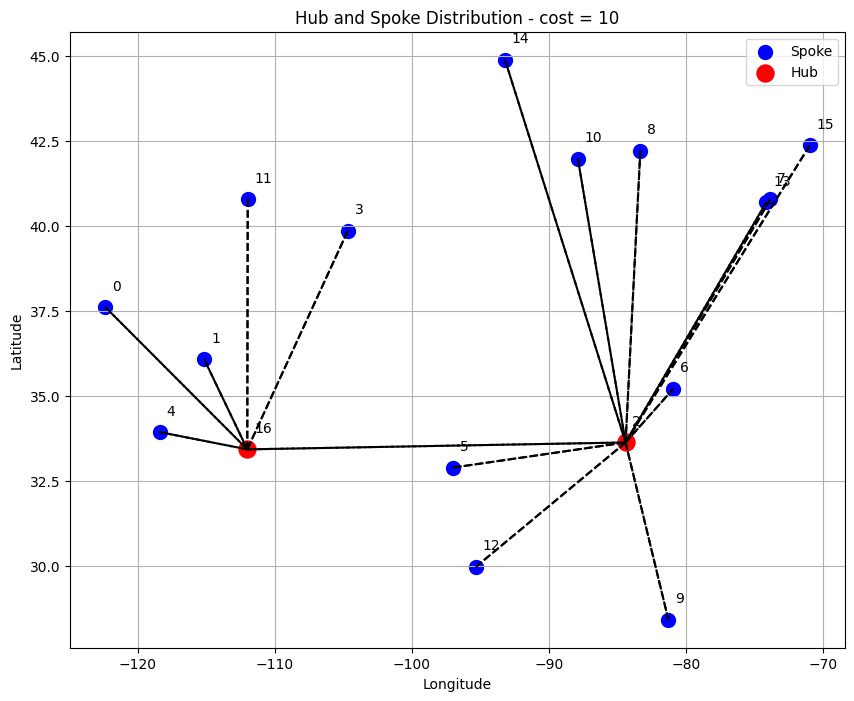

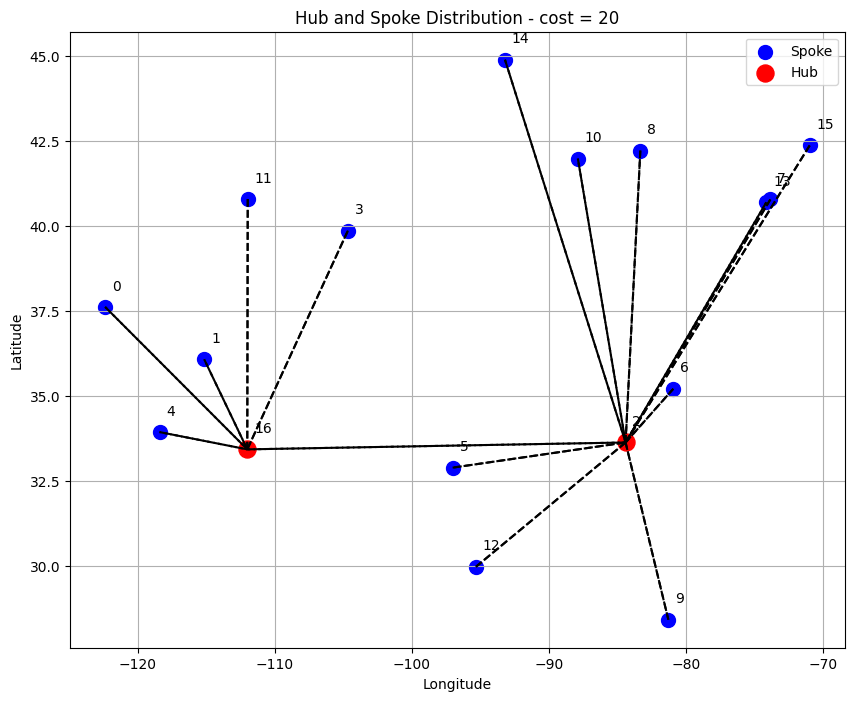

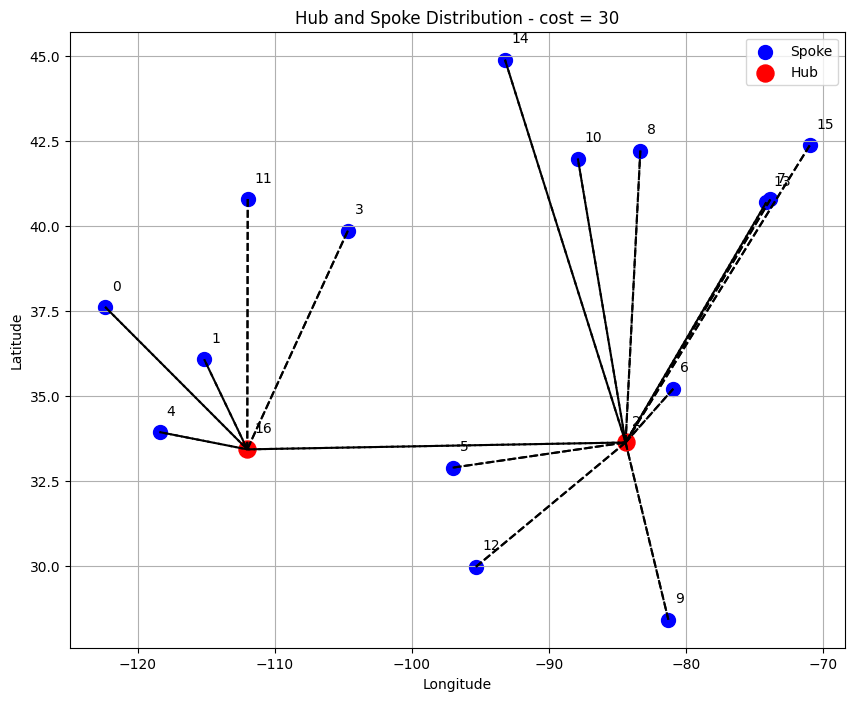

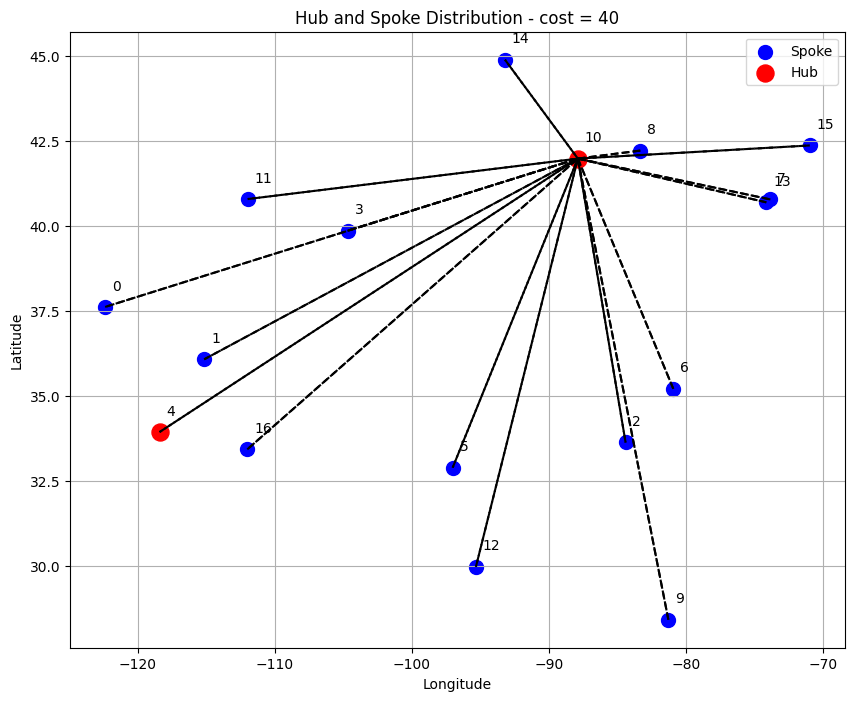

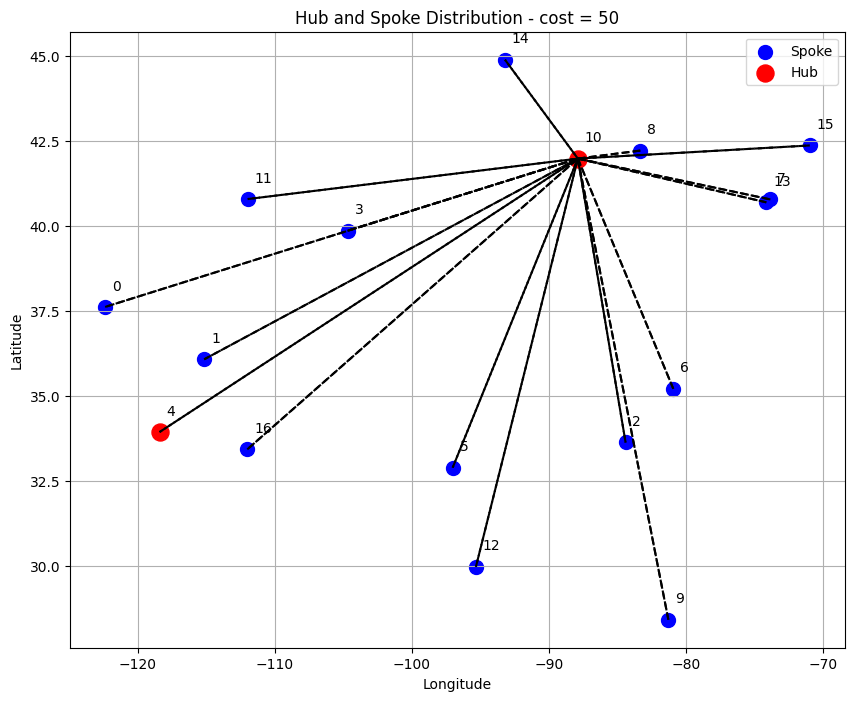

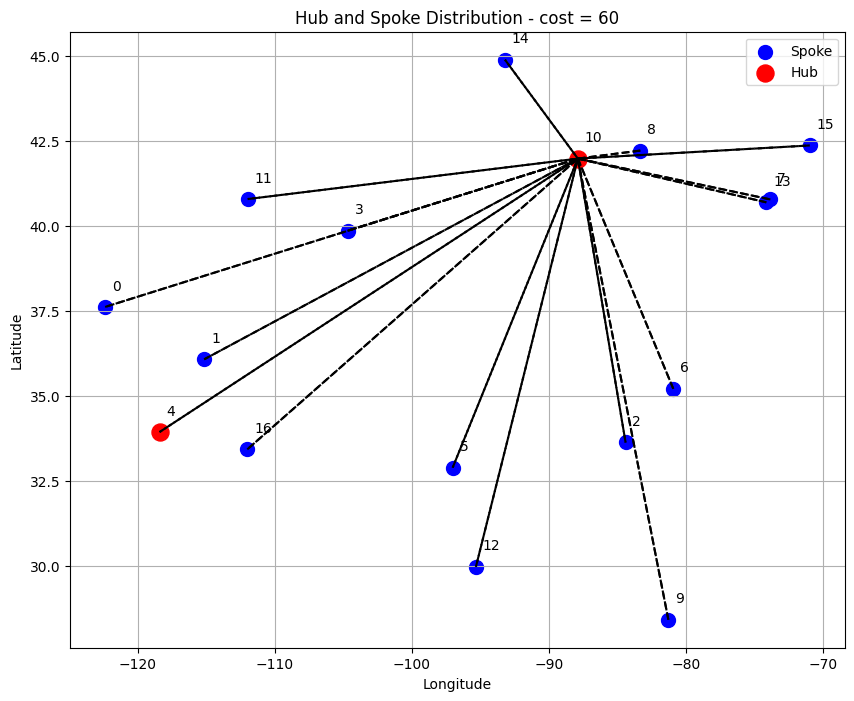

In [4]:
import matplotlib.pyplot as plt

for C in C_list:
    cost = "C_" + str(C)
    # Extract the data
    cities = cities_df[['lat', 'lon']].values
    hub_cities = [i for i in range(N) if X_dict[cost][i] > 0.5]  # Cities where x[i] is 1

    # Plot
    plt.figure(figsize=(10, 8))
    hub_label_added = False
    spoke_label_added = False

    for i in range(N):
        if i in hub_cities:
            if not hub_label_added:
                plt.scatter(cities[i][1], cities[i][0], c='red', s=150, label='Hub')  
                hub_label_added = True
            else:
                plt.scatter(cities[i][1], cities[i][0], c='red', s=150)  
        else:
            if not spoke_label_added:
                plt.scatter(cities[i][1], cities[i][0], c='blue', s=100, label='Spoke')  
                spoke_label_added = True
            else:
                plt.scatter(cities[i][1], cities[i][0], c='blue', s=100)  

        for j in range(N):
            if Y_dict[cost][i][j] > 0.5:  # If there is a link through hub k
                plt.plot([cities[i][1], cities[j][1]], [cities[i][0], cities[j][0]], 'k--')

    for i, row in cities_df.iterrows():
            plt.text(row['lon'] + 0.5, row['lat'] + 0.5, str(int(row['id'])))

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Hub and Spoke Distribution - cost = ' + str(C))
    plt.legend()
    plt.grid(True)
    plt.show()

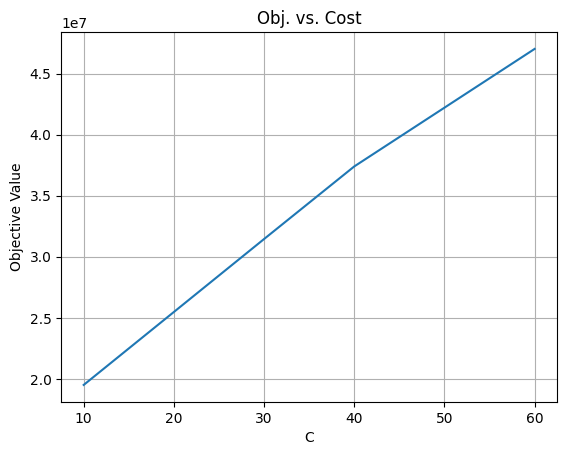

In [5]:
plt.plot(C_list, obj_dict.values())
plt.xlabel('C')
plt.ylabel('Objective Value')
plt.title('Obj. vs. Cost')
# plt.legend()
plt.grid(True)
plt.show()

In [6]:
# import numpy as np
# y = np.random.rand(5, 5)
# print(y)
# print(np.array([[y[i, j] for j in range(5)] for i in range(5)]))
# print(np.array([[y[i, j] for j in range(5)] for i in range(5)]) == y)

In [7]:
# # Initialize model
# model = Model("FreshFarm")

# N = len(cities_df)

# # Decision variables
# X = model.addVars(N, vtype=GRB.BINARY, name="x")
# Y = model.addVars(N, N, vtype=GRB.BINARY, name="y")
# Z = model.addVars(N, N, vtype=GRB.BINARY, name="z")  # Introduced for X[i] * X[j]
# W = model.addVars(N, N, N, vtype=GRB.BINARY, name="w") # Introduced for Y[i, k] * Y[k, j] * (1 - Xi * Xk * Xj)
# U = model.addVars(N, N, N, vtype=GRB.BINARY, name="u") # Introduced for Xi * Xk * Xj
# V = model.addVars(N, N, N, N, vtype=GRB.BINARY, name="v")  # Introduced for Y[i, m] * Y[m, n]  * Y[n, j] * (1 - Xi) * Xm * Xn * (1 - Xj)

# # Objective function with alpha = 0.75
# alpha = 0.75
# K = 2
# d = distances
# f = packages
# M = N

# # Objective Function
# obj_expr = LinExpr()

# # Spoke to hub, hub to hub, hub to spoke
# obj_1 = quicksum(Y[i, j] * f[(i, j)] * (d[(i, j)] - Z[i, j] * (1 - alpha) * d[(i, j)]) for i in range(N) for j in range(N) if i != j)

# # Spoke-hub-spoke, s-h-h, h-h-s
# obj_2 = quicksum(W[i, k, j] * f[(i, j)] * (d[(i, k)] + d[(k, j)] - Z[k, j] * (1 - alpha) * d[(k, j)] - Z[i, k] * (1 - alpha) * d[(i, k)])  
#                     for i in range(N) for j in range(N) for k in range(N) if i != k and i != j and k != j)

# # s-h-h-s remains unchanged as it doesn't involve direct multiplication of decision variables
# obj_3 = quicksum(V[i, m, n, j] * f[(i, j)] * (d[(i, m)] + alpha * d[(m, n)] + d[(n, j)]) 
#                     for i in range(N) for j in range(N) for m in range(N) for n in range(N) if i != m and i != n and i != j and m != n and m != j and n != j)

# # Overheaded cost
# overhead_cost_1 = quicksum(W[i, k, j] * f[(i, j)] * C for i in range(N) for j in range(N) for k in range(N) if i != k and i != j and k != j) 
# overhead_cost_2 = quicksum(V[i, m, n, j] * f[(i, j)] * 2 * C for i in range(N) for j in range(N) for m in range(N) for n in range(N) if i != m and i != n and i != j and m != n and m != j and n != j) 

# obj_expr = obj_1 + obj_2 + obj_3 + overhead_cost_1 + overhead_cost_2

# model.setObjective(obj_expr, sense=GRB.MINIMIZE)

# # Constraints
# model.addConstr(quicksum(X[i] for i in range(N)) == K)
# for i in range(N):
#     model.addConstr(Y[i, i] == 0) # No connnection to itself

#     # 1 spoke should only connect to one hub
#     model.addConstr(quicksum(Y[i, j] for j in range(N)) <= 1 + M * X[i]) 
#     model.addConstr(quicksum(Y[i, j] for j in range(N)) >= 1 - X[i])

#     for j in range(N):
#         # model.addConstr(Y[i, j] == X[i] * X[j] * (1 - X[i] + X[j]))
#         # No connection between spokes, Mush have links between hubs
#         # if Xi = Xj = 1, Yij = 1; if Xi = Xj = 0, Yij = 0; Yij = any otherwise
#         if i != j:
#             model.addConstr(Y[i, j] >= X[i] + X[j] - 1)
#             model.addConstr(Y[i, j] <= X[i] + X[j])

#         # invertible
#         model.addConstr(Y[i, j] == Y[j, i])

#         # Zij = Xi * Xj
#         model.addConstr(Z[i, j] <= X[i])
#         model.addConstr(Z[i, j] <= X[j])
#         model.addConstr(Z[i, j] >= X[i] + X[j] - 1)
#         for k in range(N):
#             # Uikj = Xi * Xk * Xj
#             model.addConstr(U[i, k, j] <= X[i])
#             model.addConstr(U[i, k, j] <= X[k])
#             model.addConstr(U[i, k, j] <= X[j])
#             model.addConstr(U[i, k, j] >= X[i] + X[k] + X[j] - 2)

#             # Wikj = Y[i, k] * Y[k, j] * (1 - Xi * Xk * Xj) = Y[i, k] * Y[k, j] * (1 - U[i, k, j])
#             model.addConstr(W[i, k, j] <= Y[i, k])
#             model.addConstr(W[i, k, j] <= Y[k, j])
#             model.addConstr(W[i, k, j] <= 1 - U[i, k, j])
#             model.addConstr(W[i, k, j] >= Y[i, k] + Y[k, j] + (1 - U[i, k, j]) - 2)

#         for m in range(N):
#             for n in range(N):

#                 # Vimnj = Y[i, m] * Y[m, n]  * Y[n, j] * (1 - Xi) * Xm * Xn * (1 - Xj)
#                 model.addConstr(V[i, m, n, j] <= Y[i, m])
#                 model.addConstr(V[i, m, n, j] <= Y[m, n])
#                 model.addConstr(V[i, m, n, j] <= Y[n, j])
#                 model.addConstr(V[i, m, n, j] <= 1 - X[i])
#                 model.addConstr(V[i, m, n, j] <= 1 - X[j])
#                 # model.addConstr(V[i, m, n, j] <= X[m])
#                 # model.addConstr(V[i, m, n, j] <= X[n])
#                 model.addConstr(V[i, m, n, j] >= Y[i, m] + Y[m, n] + Y[n, j] + 1 - X[i] + 1 - X[j] - 4)
                

# # Optimize the model
# model.optimize()

# cost = "C_" + str(C)
# X_dict[cost] = [X[i].X for i in range(N)]
# Y_dict[cost] = [[Y[i, j].X for j in range(N)] for i in range(N)]
# obj_dict[cost] = model.objVal